# Week 1 Seminar

A/B experiment analysis

In [96]:
from collections import namedtuple

import pandas as pd
import numpy as np
import scipy.stats as ss

import matplotlib.pyplot as plt

pd.set_option("display.precision", 3)

%matplotlib inline

In [97]:
experiment = "CONTEXTUAL_ARTISTS"

In [98]:
data = pd.read_json("/tmp/log/data.json", lines=True)

In [99]:
data

,message,timestamp,user,track,time,latency,recommendation,experiments
0,next,2023-04-15 19:27:45.637,1433,27509,1.00,1.293e-03,25151.0,{'CONTEXTUAL_ARTISTS': 'CONTEXTUAL_ARTISTS'}
1,next,2023-04-15 19:27:45.642,1433,25151,0.00,4.771e-04,12808.0,{'CONTEXTUAL_ARTISTS': 'CONTEXTUAL_ARTISTS'}
2,next,2023-04-15 19:27:45.645,1433,12808,0.00,4.380e-04,1592.0,{'CONTEXTUAL_ARTISTS': 'CONTEXTUAL_ARTISTS'}
3,next,2023-04-15 19:27:45.647,1433,1592,0.01,3.223e-04,247.0,{'CONTEXTUAL_ARTISTS': 'CONTEXTUAL_ARTISTS'}
4,next,2023-04-15 19:27:45.650,1433,247,0.00,3.178e-04,7668.0,{'CONTEXTUAL_ARTISTS': 'CONTEXTUAL_ARTISTS'}
...,...,...,...,...,...,...,...,...
65011,next,2023-04-15 19:28:38.324,6706,9486,0.64,2.418e-04,3010.0,{'CONTEXTUAL_ARTISTS': 'C'}
65012,next,2023-04-15 19:28:38.325,6706,3010,0.00,2.031e-04,5842.0,{'CONTEXTUAL_ARTISTS': 'C'}
65013,next,2023-04-15 19:28:38.327,6706,5842,0.36,1.845e-04,26576.0,{'CONTEXTUAL_ARTISTS': 'C'}
65014,next,2023-04-15 19:28:38.328,6706,26576,0.00,1.841e-04,2705.0,{'CONTEXTUAL_ARTISTS': 'C'}


In [100]:
data.experiments.value_counts()

experiments
{'CONTEXTUAL_ARTISTS': 'CONTEXTUAL_BASIC'}      19539
{'CONTEXTUAL_ARTISTS': 'CONTEXTUAL_ARTISTS'}    16107
{'CONTEXTUAL_ARTISTS': 'INDEXED'}               15217
{'CONTEXTUAL_ARTISTS': 'C'}                     14153
Name: count, dtype: int64

In [101]:

data["treatment"] = data["experiments"].map(lambda experiments: experiments[experiment])

In [102]:
data.head(10)

,message,timestamp,user,track,time,latency,recommendation,experiments,treatment
0,next,2023-04-15 19:27:45.637,1433,27509,1.00,1.293e-03,25151.0,{'CONTEXTUAL_ARTISTS': 'CONTEXTUAL_ARTISTS'},CONTEXTUAL_ARTISTS
1,next,2023-04-15 19:27:45.642,1433,25151,0.00,4.771e-04,12808.0,{'CONTEXTUAL_ARTISTS': 'CONTEXTUAL_ARTISTS'},CONTEXTUAL_ARTISTS
2,next,2023-04-15 19:27:45.645,1433,12808,0.00,4.380e-04,1592.0,{'CONTEXTUAL_ARTISTS': 'CONTEXTUAL_ARTISTS'},CONTEXTUAL_ARTISTS
3,next,2023-04-15 19:27:45.647,1433,1592,0.01,3.223e-04,247.0,{'CONTEXTUAL_ARTISTS': 'CONTEXTUAL_ARTISTS'},CONTEXTUAL_ARTISTS
4,next,2023-04-15 19:27:45.650,1433,247,0.00,3.178e-04,7668.0,{'CONTEXTUAL_ARTISTS': 'CONTEXTUAL_ARTISTS'},CONTEXTUAL_ARTISTS
5,last,2023-04-15 19:27:45.652,1433,7668,0.00,9.489e-05,NaN,{'CONTEXTUAL_ARTISTS': 'CONTEXTUAL_ARTISTS'},CONTEXTUAL_ARTISTS
6,next,2023-04-15 19:27:45.660,1433,27509,1.00,4.547e-04,4564.0,{'CONTEXTUAL_ARTISTS': 'CONTEXTUAL_ARTISTS'},CONTEXTUAL_ARTISTS
7,next,2023-04-15 19:27:45.665,3720,8,1.00,6.003e-04,8386.0,{'CONTEXTUAL_ARTISTS': 'C'},C
8,next,2023-04-15 19:27:45.666,1433,4564,0.00,2.112e-04,37104.0,{'CONTEXTUAL_ARTISTS': 'CONTEXTUAL_ARTISTS'},CONTEXTUAL_ARTISTS
9,next,2023-04-15 19:27:45.669,3720,8386,0.01,2.582e-04,18957.0,{'CONTEXTUAL_ARTISTS': 'C'},C


## Visualize sessions

In [103]:
Session = namedtuple("Session", ["timestamp", "tracks", "time", "latency"])

def sessionize(user_data):
    sessions = []
    session = None
    for _, row in user_data.sort_values("timestamp").iterrows():
        if session is None:
            session = Session(row["timestamp"], 0, 0, 0)
        
        session = session._replace(
            tracks = session.tracks + 1, 
            time = session.time + row["time"],
            latency = session.latency + row["latency"] * 1000,
        )
        
        if row["message"] == "last":
            sessions.append(session._asdict())
            session = None
    return sessions

In [104]:
sessions = (
    data
    .groupby(["user", "treatment"])
    .apply(sessionize)
    .explode()
    .apply(pd.Series)
)

In [105]:
sessions

timestamp  tracks  time  latency
user treatment                                                      
0    INDEXED          2023-04-15 19:28:21.662       6  1.00    1.903
     INDEXED          2023-04-15 19:28:27.231       6  1.00    3.028
5    C                2023-04-15 19:28:12.212       9  3.68    1.682
8    INDEXED          2023-04-15 19:27:58.534       8  2.88    2.134
     INDEXED          2023-04-15 19:27:58.850       8  2.73    3.160
...                                       ...     ...   ...      ...
9997 INDEXED          2023-04-15 19:28:34.542       6  1.11    1.191
     INDEXED          2023-04-15 19:28:34.891       6  1.41    3.112
9998 CONTEXTUAL_BASIC 2023-04-15 19:27:48.726       6  1.00    1.312
     CONTEXTUAL_BASIC 2023-04-15 19:28:09.886      11  5.45    2.697
9999 INDEXED          2023-04-15 19:28:03.580       6  1.11    1.798

[8000 rows x 4 columns]

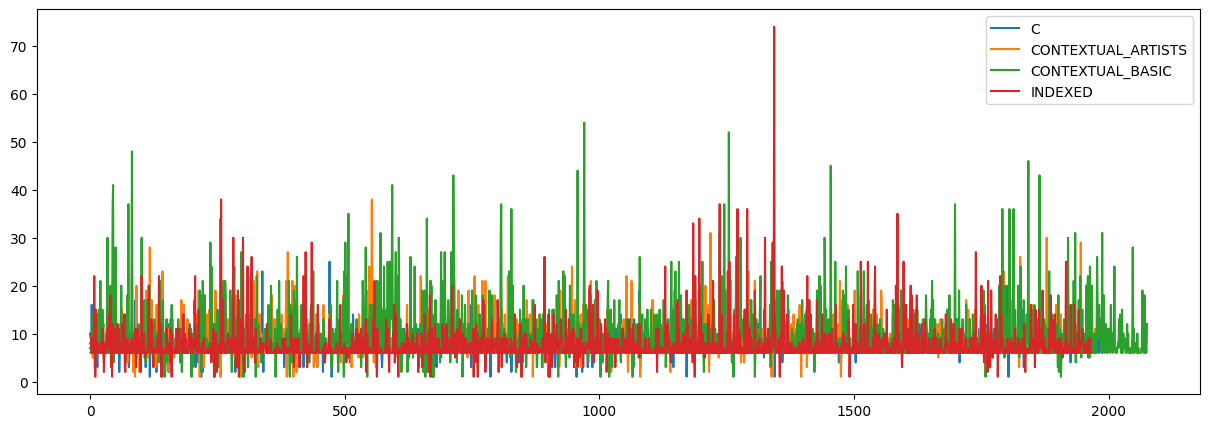

In [106]:
figure, ax = plt.subplots(figsize=(15, 5))
for treatment, treatment_sessions in sessions.groupby("treatment"):
    reindexed_treatment_sessions = treatment_sessions.sort_values("timestamp").reset_index()
    ax.plot(reindexed_treatment_sessions.index, reindexed_treatment_sessions["tracks"], label=treatment)
ax.legend()
pass

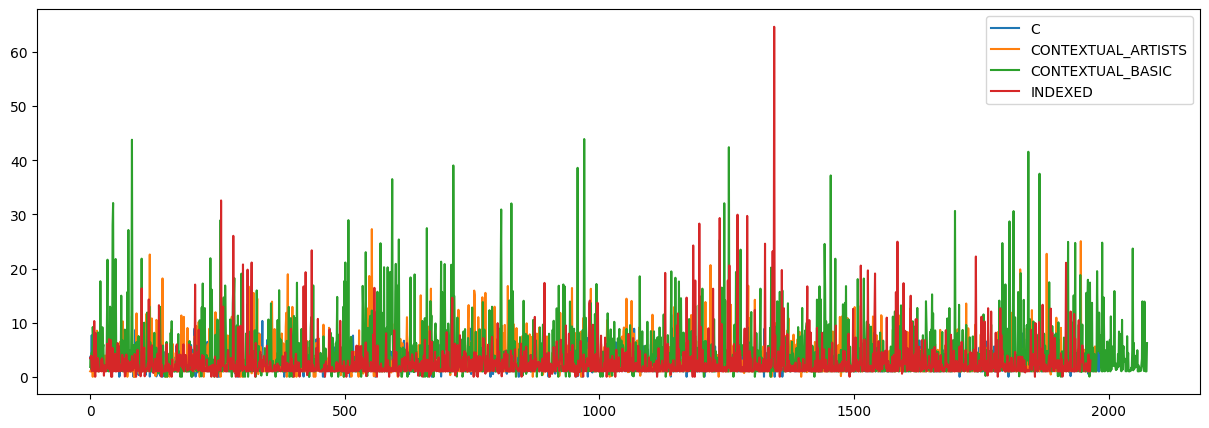

In [107]:
figure, ax = plt.subplots(figsize=(15, 5))
for treatment, treatment_sessions in sessions.groupby("treatment"):
    reindexed_treatment_sessions = treatment_sessions.sort_values("timestamp").reset_index()
    ax.plot(reindexed_treatment_sessions.index, reindexed_treatment_sessions["time"], label=treatment)
ax.legend()
pass

## Analyze the experiment

In [108]:
user_level_data = (
  sessions
    .reset_index()
    .groupby(["user", "treatment"])
    .agg(
        {
            "timestamp": "count",
            "tracks": "sum",
            "time": "sum",
            "latency": "sum"
        }
    )
)

user_level_data["sessions"] = user_level_data["timestamp"]
user_level_data["mean_request_latency"] = user_level_data["latency"] / user_level_data["tracks"]
user_level_data["mean_tracks_per_session"] = user_level_data["tracks"] / user_level_data["sessions"]
user_level_data["mean_time_per_session"] = user_level_data["time"] / user_level_data["sessions"]

metrics = [
    "time", 
    "sessions", 
    "mean_request_latency", 
    "mean_tracks_per_session", 
    "mean_time_per_session"
]

user_level_metrics = user_level_data[metrics].copy().reset_index()

In [109]:
treatment_level_metrics = (
    user_level_metrics
    .groupby("treatment")[metrics]
    .agg(["count", "mean", "var"])
)

In [110]:
def dof(n_0, n_1, s2_0, s2_1):
    numerator = (s2_0 / n_0 + s2_1 / n_1) * (s2_0 / n_0 + s2_1 / n_1)
    denominator = s2_0 * s2_0 / n_0 / n_0 / (n_0 - 1) + s2_1 * s2_1 / n_1 / n_1 / (n_1 - 1)
    return numerator / denominator


def ci(n_0, n_1, s2_0, s2_1, alpha=0.05):
    return ss.t.ppf(1 - alpha/2, dof(n_0, n_1, s2_0, s2_1)) * np.sqrt(s2_0 / n_0 + s2_1 / n_1)


effects = []

control = [data for treatment, data in treatment_level_metrics.iterrows() if treatment == "C"][0]

for treatment, row in treatment_level_metrics.iterrows():
    if treatment == "C":
        continue
    
    for metric in metrics:
        control_mean = control[metric]["mean"]
        treatment_mean = row[metric]["mean"]
        
        effect = treatment_mean - control_mean
        conf_int = ci(
            control[metric]["count"],
            row[metric]["count"],
            control[metric]["var"],
            row[metric]["var"],
        )
        effects.append({
            "treatment": treatment,
            "metric": metric,
            "control_mean": control_mean,
            "treatment_mean": treatment_mean,
            "effect": effect / control_mean * 100,
            "lower": (effect - conf_int) / control_mean * 100,
            "upper": (effect + conf_int) / control_mean * 100,
            "significant": (effect + conf_int) * (effect - conf_int) > 0
        })

In [111]:
def color(value):
    return 'color:red;' if value < 0 else 'color:green;'

def background(value):
    return 'color:white;background-color:green' if value else 'color:white;background-color:red'
        

(
    pd.DataFrame(effects)[[
        "treatment", 
        "metric",
        "effect", 
        "upper", 
        "lower", 
        "control_mean", 
        "treatment_mean",
        "significant"
    ]]
    .sort_values(["metric", "treatment"], ascending=False)
    .style
    .applymap(color, subset=["effect", "upper", "lower"])
    .applymap(background, subset=["significant"])
)

,treatment,metric,effect,upper,lower,control_mean,treatment_mean,significant
10,INDEXED,time,30.036118,43.400659,16.671577,4.381493,5.697524,True
5,CONTEXTUAL_BASIC,time,118.329437,138.754899,97.903976,4.381493,9.566090,True
0,CONTEXTUAL_ARTISTS,time,47.794560,59.584665,36.004455,4.381493,6.475609,True
11,INDEXED,sessions,1.767313,7.756747,-4.222120,2.043254,2.079365,False
6,CONTEXTUAL_BASIC,sessions,5.946424,12.015103,-0.122254,2.043254,2.164755,False
1,CONTEXTUAL_ARTISTS,sessions,0.582233,6.409108,-5.244641,2.043254,2.055151,False
13,INDEXED,mean_tracks_per_session,8.822416,11.945595,5.699238,7.115972,7.743772,True
8,CONTEXTUAL_BASIC,mean_tracks_per_session,29.171701,33.369245,24.974157,7.115972,9.191821,True
3,CONTEXTUAL_ARTISTS,mean_tracks_per_session,14.655635,17.524861,11.786409,7.115972,8.158862,True
14,INDEXED,mean_time_per_session,29.768670,39.846286,19.691054,2.120865,2.752218,True


In [87]:
r = 400/(2*np.pi)

In [89]:
np.pi*r**2

12732.395447351626

In [90]:
100*100

10000